
# Configuration section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import itertools

In [ ]:
def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/SS_lab3/"

# Loading and preparing data

In [ ]:
def split_dataset(dataset, proportion=0.3):
    marked_train_set = int(len(dataset) * proportion)
    unmarked_train_set = len(dataset) - marked_train_set
    marked, unmarked = torch.utils.data.random_split(dataset, [marked_train_set, unmarked_train_set])
    return {"marked_train": marked, "unmarked_train": unmarked}

In [ ]:
def create_dataloaders(image_datasets, batch_size=64, shuffle=True):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=shuffle
    ) for x in image_datasets.keys()}

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.transforms.RandomAffine(0, translate=(1/16,1/16)),
    torchvision.transforms.RandomHorizontalFlip(),
])

In [ ]:
image_datasets = {x: torchvision.datasets.CIFAR10(
      root=folder_path + "TrainingData",
      train=x == 'train',
      download=True,
      transform=transform
    ) for x in ['train', 'val']}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
reference_dataloaders = create_dataloaders(image_datasets)

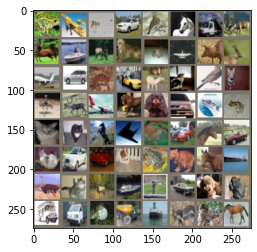

In [ ]:
inputs, classes = next(iter(reference_dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
unsupervised_image_datsets = split_dataset(image_datasets['train'])
unsupervised_image_datsets['val'] = image_datasets['val']

In [ ]:
first_model_dataloaders = create_dataloaders(unsupervised_image_datsets)

In [ ]:
second_model_dataloaders = create_dataloaders(unsupervised_image_datsets)
second_model_dataloaders['unmarked_train'] = first_model_dataloaders['unmarked_train']

# Training models

In [ ]:
def train_model(model_student, criterion, optimizer, dataloaders_dict, model_teacher=None, num_epochs=10):
    y_loss = {phase: [] for phase in dataloaders_dict.keys()}
    y_acc = {phase: [] for phase in dataloaders_dict.keys()}

    if model_teacher is not None:
        model_teacher.eval()

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in dataloaders_dict.keys():
                if 'train' in phase:
                    model_student.train()
                else:
                    model_student.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders_dict[phase]:
                    inputs = inputs.to(device)

                    if phase == 'unmarked_train':
                        teacher_outputs = model_teacher(inputs)
                        _, labels_to_use = torch.max(teacher_outputs, 1)
                    else:
                        labels_to_use = labels
                        
                    labels_to_use = labels_to_use.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled('train' in phase):
                        outputs = model_student(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels_to_use)

                        if 'train' in phase:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels_to_use)

                dataset_size = len(dataloaders_dict[phase].dataset)
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model_student.state_dict())
                  
    model_student.load_state_dict(best_model_wts)
    return model_student, y_loss, y_acc

In [ ]:
def draw_graphs(y_loss, y_acc, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
        ax1.plot(x_epochs, y_acc[phase], label=phase)
    
    ax0.legend()
    ax1.legend()

    plt.show()

## Defining a model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training a reference model

In [ ]:
reference_model = Net()
reference_model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
ref_optimizer = optim.SGD(reference_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
reference_model, reference_y_loss, reference_y_acc = train_model(reference_model, criterion, ref_optimizer, reference_dataloaders)

Epoch 1/10
----------
train Loss: 1.7602 Acc: 0.3520
val Loss: 1.5021 Acc: 0.4519
Epoch 2/10
----------
train Loss: 1.4036 Acc: 0.4966
val Loss: 1.2802 Acc: 0.5399
Epoch 3/10
----------
train Loss: 1.2923 Acc: 0.5417
val Loss: 1.2041 Acc: 0.5697
Epoch 4/10
----------
train Loss: 1.2121 Acc: 0.5723
val Loss: 1.2806 Acc: 0.5512
Epoch 5/10
----------
train Loss: 1.1632 Acc: 0.5897
val Loss: 1.1962 Acc: 0.5667
Epoch 6/10
----------
train Loss: 1.1242 Acc: 0.6035
val Loss: 1.1316 Acc: 0.6058
Epoch 7/10
----------
train Loss: 1.0834 Acc: 0.6158
val Loss: 1.1077 Acc: 0.6113
Epoch 8/10
----------
train Loss: 1.0530 Acc: 0.6291
val Loss: 1.0573 Acc: 0.6286
Epoch 9/10
----------
train Loss: 1.0319 Acc: 0.6373
val Loss: 1.1178 Acc: 0.6153
Epoch 10/10
----------
train Loss: 1.0139 Acc: 0.6433
val Loss: 1.0325 Acc: 0.6322


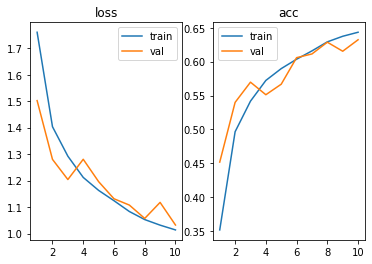

In [ ]:
draw_graphs(reference_y_loss, reference_y_acc, reference_y_loss.keys())

In [ ]:
torch.save(reference_model.state_dict(), folder_path + 'ModelWeights/reference_model.pth')

## Training models on labeled data

### First model

In [ ]:
first_model_teacher = Net()
first_model_teacher.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
first_optimizer = optim.SGD(first_model_teacher.parameters(), lr=0.01, momentum=0.9)

In [ ]:
first_model_teacher, first_t_y_loss, first_t_y_acc = train_model(first_model_teacher, criterion, first_optimizer, dict(itertools.islice(first_model_dataloaders.items(), 0, None, 2)))

Epoch 1/10
----------
marked_train Loss: 2.0698 Acc: 0.2297
val Loss: 1.8322 Acc: 0.3105
Epoch 2/10
----------
marked_train Loss: 1.7288 Acc: 0.3619
val Loss: 1.6180 Acc: 0.3961
Epoch 3/10
----------
marked_train Loss: 1.5770 Acc: 0.4207
val Loss: 1.5358 Acc: 0.4280
Epoch 4/10
----------
marked_train Loss: 1.4968 Acc: 0.4548
val Loss: 1.4810 Acc: 0.4595
Epoch 5/10
----------
marked_train Loss: 1.4220 Acc: 0.4850
val Loss: 1.4074 Acc: 0.4927
Epoch 6/10
----------
marked_train Loss: 1.3561 Acc: 0.5143
val Loss: 1.3992 Acc: 0.4937
Epoch 7/10
----------
marked_train Loss: 1.3317 Acc: 0.5225
val Loss: 1.3113 Acc: 0.5329
Epoch 8/10
----------
marked_train Loss: 1.2754 Acc: 0.5436
val Loss: 1.2672 Acc: 0.5494
Epoch 9/10
----------
marked_train Loss: 1.2524 Acc: 0.5551
val Loss: 1.2620 Acc: 0.5537
Epoch 10/10
----------
marked_train Loss: 1.2138 Acc: 0.5656
val Loss: 1.2616 Acc: 0.5545


### Second model

In [ ]:
second_model_teacher = Net()
second_model_teacher.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
second_optimizer = optim.SGD(second_model_teacher.parameters(), lr=0.01, momentum=0.9)

In [ ]:
second_model_teacher, second_t_y_loss, second_t_y_acc = train_model(second_model_teacher, criterion, second_optimizer, dict(itertools.islice(second_model_dataloaders.items(), 0, None, 2)))

Epoch 1/10
----------
marked_train Loss: 2.1408 Acc: 0.2035
val Loss: 1.8747 Acc: 0.3003
Epoch 2/10
----------
marked_train Loss: 1.7453 Acc: 0.3565
val Loss: 1.6300 Acc: 0.4032
Epoch 3/10
----------
marked_train Loss: 1.5917 Acc: 0.4131
val Loss: 1.5204 Acc: 0.4462
Epoch 4/10
----------
marked_train Loss: 1.4905 Acc: 0.4560
val Loss: 1.4340 Acc: 0.4766
Epoch 5/10
----------
marked_train Loss: 1.4268 Acc: 0.4839
val Loss: 1.3708 Acc: 0.5048
Epoch 6/10
----------
marked_train Loss: 1.3716 Acc: 0.5041
val Loss: 1.3490 Acc: 0.5154
Epoch 7/10
----------
marked_train Loss: 1.3389 Acc: 0.5257
val Loss: 1.2996 Acc: 0.5315
Epoch 8/10
----------
marked_train Loss: 1.2795 Acc: 0.5454
val Loss: 1.3563 Acc: 0.5210
Epoch 9/10
----------
marked_train Loss: 1.2672 Acc: 0.5469
val Loss: 1.3660 Acc: 0.5132
Epoch 10/10
----------
marked_train Loss: 1.2273 Acc: 0.5648
val Loss: 1.2779 Acc: 0.5455


## Retraining models using pseudo-labels

### First model

In [ ]:
first_model = Net()
first_model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
first_optimizer = optim.SGD(first_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
first_model, first_s_y_loss, first_s_y_acc = train_model(first_model, criterion, first_optimizer, first_model_dataloaders, model_teacher=second_model_teacher)

Epoch 1/10
----------
marked_train Loss: 2.0663 Acc: 0.2377
unmarked_train Loss: 1.3008 Acc: 0.5268
val Loss: 1.6477 Acc: 0.4494
Epoch 2/10
----------
marked_train Loss: 1.4916 Acc: 0.4615
unmarked_train Loss: 1.0297 Acc: 0.6241
val Loss: 1.9306 Acc: 0.4563
Epoch 3/10
----------
marked_train Loss: 1.3880 Acc: 0.5017
unmarked_train Loss: 0.9116 Acc: 0.6649
val Loss: 1.7894 Acc: 0.4795
Epoch 4/10
----------
marked_train Loss: 1.3252 Acc: 0.5309
unmarked_train Loss: 0.8549 Acc: 0.6861
val Loss: 1.6374 Acc: 0.5114
Epoch 5/10
----------
marked_train Loss: 1.2910 Acc: 0.5445
unmarked_train Loss: 0.8205 Acc: 0.7001
val Loss: 1.7073 Acc: 0.5028
Epoch 6/10
----------
marked_train Loss: 1.2653 Acc: 0.5551
unmarked_train Loss: 0.7914 Acc: 0.7102
val Loss: 1.6345 Acc: 0.5360
Epoch 7/10
----------
marked_train Loss: 1.2366 Acc: 0.5644
unmarked_train Loss: 0.7694 Acc: 0.7135
val Loss: 1.8459 Acc: 0.5207
Epoch 8/10
----------
marked_train Loss: 1.2323 Acc: 0.5684
unmarked_train Loss: 0.7532 Acc: 0.72

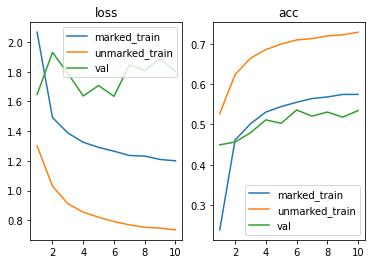

In [ ]:
draw_graphs(first_s_y_loss, first_s_y_acc, first_s_y_loss.keys())

In [ ]:
torch.save(first_model.state_dict(), folder_path + 'ModelWeights/first_model.pth')

### Second model

In [ ]:
second_model = Net()
second_model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
second_optimizer = optim.SGD(second_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
second_model, second_s_y_loss, second_s_y_acc = train_model(second_model, criterion, second_optimizer, second_model_dataloaders, model_teacher=first_model_teacher)

Epoch 1/10
----------
marked_train Loss: 2.0140 Acc: 0.2565
unmarked_train Loss: 1.2696 Acc: 0.5348
val Loss: 1.7240 Acc: 0.4538
Epoch 2/10
----------
marked_train Loss: 1.4604 Acc: 0.4751
unmarked_train Loss: 0.9558 Acc: 0.6441
val Loss: 1.6755 Acc: 0.5007
Epoch 3/10
----------
marked_train Loss: 1.3473 Acc: 0.5233
unmarked_train Loss: 0.8484 Acc: 0.6898
val Loss: 1.6216 Acc: 0.5061
Epoch 4/10
----------
marked_train Loss: 1.2931 Acc: 0.5458
unmarked_train Loss: 0.7890 Acc: 0.7090
val Loss: 1.6464 Acc: 0.5264
Epoch 5/10
----------
marked_train Loss: 1.2521 Acc: 0.5614
unmarked_train Loss: 0.7592 Acc: 0.7176
val Loss: 1.6530 Acc: 0.5337
Epoch 6/10
----------
marked_train Loss: 1.2427 Acc: 0.5681
unmarked_train Loss: 0.7353 Acc: 0.7243
val Loss: 1.7198 Acc: 0.5449
Epoch 7/10
----------
marked_train Loss: 1.2286 Acc: 0.5698
unmarked_train Loss: 0.7105 Acc: 0.7348
val Loss: 1.7642 Acc: 0.5311
Epoch 8/10
----------
marked_train Loss: 1.2276 Acc: 0.5692
unmarked_train Loss: 0.7165 Acc: 0.73

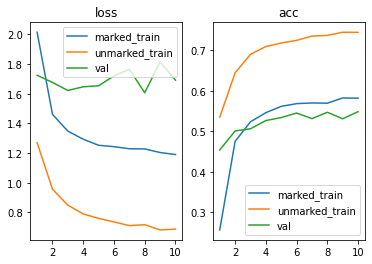

In [ ]:
draw_graphs(second_s_y_loss, second_s_y_acc, second_s_y_loss.keys())

In [ ]:
torch.save(second_model.state_dict(), folder_path + 'ModelWeights/second_model.pth')

In [ ]:
def visualize_acc_preds(first_model, second_model, dataloader, num_images=6):
    first_model.eval()
    second_model.eval()
    images_so_far = 0
    correct = 0
    total = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            first_outputs = first_model(inputs)
            second_outputs = second_model(inputs)
            _, preds = torch.max((first_outputs + second_outputs)/2, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {dataloader.dataset.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

Accuracy of the network on the 10000 test images: 56 %



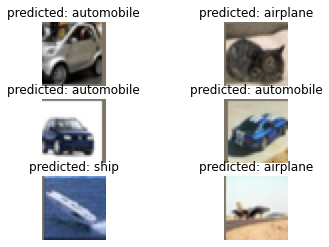

In [ ]:
visualize_acc_preds(first_model, second_model, reference_dataloaders['val'])

# Висновки

В рамках виконання лабораторної роботи був реалізований алгоритм напівкерованого навчання Co-training. Для цього була використана проста модель згорткової неронної мережі. Ця архітектура була використана і у моделі «вчителі», і у моделі «учні». На відміну від оригінальної статі у моїй реалізації не використовувались змагальні атаки. Їх використання довзволяє гарантувати те, що моделі не згорнуться в одну(collapce into one another). Навіть попри це отримані результати є деволі непоганими, досягнута точність у 56% відсотків не є критично меншою ніж у референсної моделі. 

# Відповіді на запитання



1.   В чому полягає ідея Multiview training?
У використанні наборів даних, які містять різні "представлення" даних, що досліджуються. Такий метод використовується у випадках, коли дані неможливо описати єдиним видом.

2.   Як класифікують методи Multiview training?
co-training, co-regularization, margin consistency

3.   Де застосовують multiview training?
У випадках коли робота ведеться із декількома наборами даних, які іморвірно є незалежними, але описують один об'єкт. Стан пацієнта може описуватись результатами його аналізів та кардіогрмою одночасно. Відповідно формується два набори даних.


4.   Чим відрізняється co-training від democratic co-training?
co-training навчає дві моделі на різних представленнях даних.
democratic co-training навчає дві моделі різні за структурою на одних і тих самих даних.
